In [326]:
from scipy.io import loadmat
import numpy as np
from PIL import Image
from scipy.special import iv  # Bessel Function
import matplotlib.pyplot as plt

In [3]:
mat_data = loadmat("data/assignmentImageDenoising_phantom.mat")
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'imageNoiseless', 'imageNoisy'])


In [380]:
def save_image(data: np.ndarray, filename):
    """
    Edatatracts image data from a .mat file, normalizes it, and saves it as a PNG file.

    Parameters:
        data (np.ndarray): input data
        filename (str): Name of the file to save the image to.
    """
    data_normalized = (255 * (data - np.min(data)) / (np.max(data) - np.min(data))).astype(np.uint8)

    # Save the image
    plt.imshow(data_normalized, cmap='jet')
    plt.savefig(filename)

Generate Images from .mat file

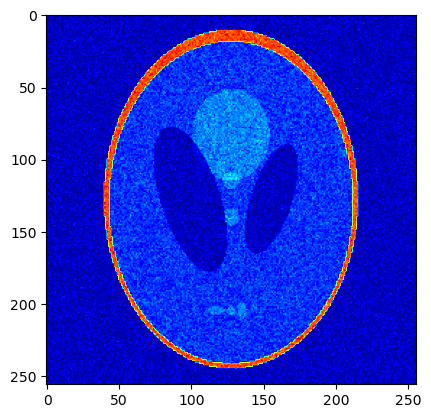

In [381]:
save_image(mat_data['imageNoiseless'], 'image_noiseless.png')
save_image(mat_data['imageNoisy'], 'image_noisy.png')

In [179]:
def RRMSE(noisy_data: np.ndarray, noiseless_data: np.ndarray) -> float:
    """
    Computes the Relative Root Mean Squared Error (RRMSE) between the noisy and noiseless data.
    """

    return np.sqrt(np.sum(np.square((noisy_data - noiseless_data)))) / np.sqrt(np.sum(np.square(noiseless_data)))


Gaussian Noise Model

In [8]:
def grad_log_likelihood(data: np.ndarray, model: np.ndarray) -> np.ndarray:
    """
    Returns:
        numpy.ndarray: The gradient of the log likelihood.
    """
    return model-data

Rician Noise Model

In [178]:
def grad_rician_log_likelihood(data: np.ndarray, model: np.ndarray, beta: float) -> np.ndarray:
    """
    Compute the gradient of the Rician log likelihood.

    Parameters:
        data (np.ndarray): The observed data.
        model (np.ndarray): The model prediction.
        beta (float): Regularization parameter for the prior.

    Returns:
        np.ndarray: The gradient of the log likelihood with respect to the model.
    """
    eps = 1e-6  # Small constant to prevent division issues
    sigma = 1

    sigma_sq = sigma**2 + eps

    grad = np.zeros_like(model)

    grad += model / sigma_sq

    bessel_ratio = iv(1, np.clip((1-beta) * (data * model), -700, 700) / sigma_sq) / (iv(0, np.clip((1-beta) * (data * model) / sigma_sq, -700, 700) + eps))

    grad -= (data / sigma_sq) * bessel_ratio

    return grad


A) MRF Model with quadratic prior g(u) = |u|^2 and potential function h(u, v) = |u - v|^2

In [494]:
def grad_log_prior_quad(data: np.ndarray) -> np.ndarray:

    diff = np.zeros_like(data)
    for axis in range(data.ndim):
        diff += np.abs(data - np.roll(data, shift=-1, axis=axis))

    return diff

In [495]:
obj_quad = []
def gradient_descent_quad(data, lr=0.01, decay=0.05, max_iter=500, alpha=0.99, tol=1e-6):
    model = data.copy()
    step_size = lr
    for t in range(max_iter):
        rician = grad_rician_log_likelihood(data, model, alpha)
        grad = alpha*rician+ (1-alpha)*grad_log_prior_quad(model)
        obj_quad.append(np.sum(np.square(rician)))
        step_size /= (1 + decay)
        if step_size < tol:
            break
        model = model - step_size * grad
    return model

In [496]:
ans_quad = gradient_descent_quad(mat_data['imageNoisy'])
print("Denoised Image", RRMSE(ans_quad, mat_data['imageNoiseless']))
print("Original Image", RRMSE(mat_data['imageNoisy'], mat_data['imageNoiseless']))

Denoised Image 0.2977369739000864
Original Image 0.29857915712437444


Optimal Paremters
alpha = 0.99
learning rate = 0.01
decay = 0.05
min step size = 1e-6

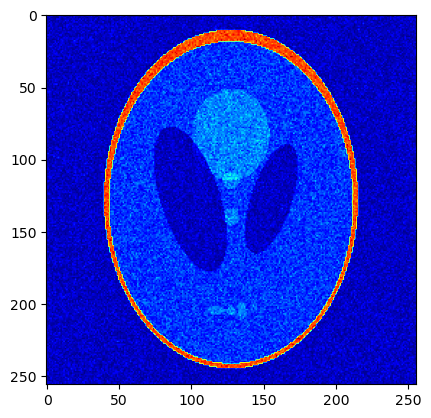

In [497]:
save_image(ans_quad, "denoised_quad.png")

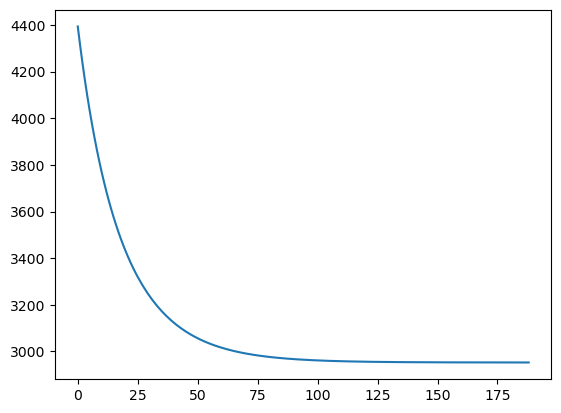

In [498]:
plt.plot(obj_quad)
plt.show()

B) MRF Model with Huber-Function: g(u) = 0.5 * u^2 if |u| <= gamma, else gamma * |u| - 0.5 * gamma ^2

In [396]:
def grad_huber(data: np.ndarray, gamma=0.1) -> np.ndarray:
    """
    Computes the gradient of the log prior using a potential function based on neighboring differences.

    Parameters:
        data (np.ndarray): Image data.
        gamma (float): Threshold value.

    Returns:
        np.ndarray: The gradient of the log prior.
    """

    diff = np.zeros_like(data)
    for axis in range(data.ndim):
        diff += np.abs(data - np.roll(data, shift=-1, axis=axis))

    mask = diff <= gamma
    return np.where(mask, diff, gamma * np.sign(diff))

In [499]:
def calc_huber(data: np.ndarray, gamma=0.1):
    diff = np.zeros_like(data)
    for axis in range(data.ndim):
        diff += np.abs(data - np.roll(data, shift=-1, axis=axis))
    mask = diff <= gamma
    return np.sum(np.square(np.where(mask, 0.5*np.square(diff), gamma * diff - 0.5 * gamma ** 2)))

In [470]:
obj_huber = []
def gradient_descent_huber(data, lr=0.01, decay=0.05, max_iter=500, alpha = 0.99, tol=1e-5):
    step_size = lr
    model = data.copy()
    for t in range(max_iter):
        grad = (1-alpha) * (grad_rician_log_likelihood(data, model, alpha)) + alpha * grad_huber(model)
        step_size /= (1 + decay)
        if step_size < tol:
            break
        model = model - step_size * grad
        print(RRMSE(model, mat_data['imageNoiseless']))
        obj_huber.append(calc_huber(model))
    return model

In [471]:
ans_huber = gradient_descent_huber(mat_data['imageNoisy'])
print("Denoised Image", RRMSE(ans_huber, mat_data['imageNoiseless']))
print("Original Image", RRMSE(mat_data['imageNoisy'], mat_data['imageNoiseless']))

0.29321320372347476
0.28831115479528074
0.28384112552319074
0.2797725279776924
0.27607611385331293
0.27272400940189
0.2696897409196881
0.26694824973511505
0.26447589620829365
0.262250452763059
0.26025108640467437
0.25845833152061565
0.2568540540136025
0.25542140797908586
0.25414478622226794
0.25300976592431995
0.2520030507272562
0.25111241042556953
0.2503266193430417
0.24963539434638926
0.24902933331301125
0.24849985473550112
0.24803913901632724
0.24764007188601142
0.2472961902696606
0.2470016308310582
0.24675108134105458
0.24653973494738096
0.24636324736549517
0.246217696963596
0.24609954767832648
0.24600561466967483
0.24593303260295446
0.24587922643133325
0.24584188454313474
0.24581893413308323
0.24580851865498707
0.24580897721431721
0.24581882576213068
0.24583673995629693
0.2458615395615787
0.24589217426645374
0.24592771080135573
0.2459673212500418
0.24601027245288437
0.24605591640790223
0.2461036815821942
0.24615306505303788
0.24620362540422466
0.2462549763091773
0.2463067807380283

Optimal Parameters
alpha = 0.99
learning rate = 0.01
decay = 0.05
min step size = 1e-5

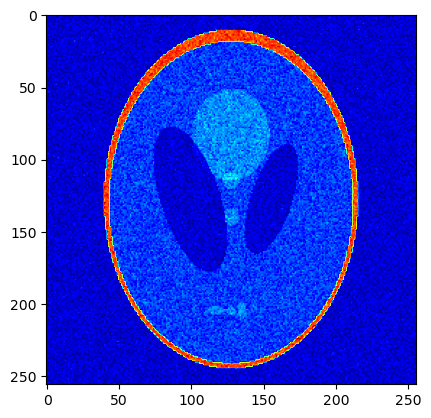

In [453]:
save_image(ans_huber, "denoised_huber.png")

In [ ]:
plt.plot(obj_huber)
plt.show()

Discontinuity-adaptive function: g3 (u) := γ|u| − γ^2 log(1 + |u|/γ), where 0 < γ < ∞ is a
constant.

In [463]:
def grad_discontinuity_adaptive(data: np.ndarray, gamma=0.1) -> np.ndarray:
    """
    Computes the gradient of the log prior using a potential function based on neighboring differences.

    Parameters:
        data (np.ndarray): Image data.
        gamma (float): Constant

    Returns:
        np.ndarray: The gradient of the log prior.
    """

    diff = np.zeros_like(data)
    for axis in range(data.ndim):
        diff += np.abs(data - np.roll(data, shift=-1, axis=axis))

    return gamma * np.sign(diff) - gamma*diff/(gamma+diff) * np.sign(diff)

In [464]:
def calc_adapt(data:np.ndarray, gamma=0.1) -> float:
    diff = np.zeros_like(data)
    for axis in range(data.ndim):
        diff += np.abs(data - np.roll(data, shift=-1, axis=axis))
    return np.sum(gamma * diff - gamma ** 2 * np.log(1 + diff / gamma))

0.2945705303315137
0.29080459892000554
0.2872684610140667
0.28394970680014053
0.28083641621277533
0.27791715566637815
0.27518097373359435
0.27261739570932325
0.2702164170351152
0.2679684955910835
0.2658645428909047
0.2638959142395991
0.26205439793342306
0.26033220359638576
0.2587219497588032
0.2572166507902321
0.25580970330246894
0.25449487213850963
0.25326627606092267
0.2521183732484674
0.25104594670347075
0.2500440896648863
0.24910819111350108
0.24823392144678158
0.24741721839165495
0.24665427321436112
0.24594151727758565
0.24527560898654696
0.24465342115768823
0.24407202883618478
0.24352869758168183
0.24302087223554458
0.24254616617743516
0.24210235107422193
0.2416873471200464
0.24129921376278682
0.2409361409091296
0.24059644059794008
0.24027853912957048
0.2399809696371077
0.2397023650842987
0.23944145167395814
0.2391970426500141
0.23896803247594828
0.238753391372201
0.2385521601951036
0.2383634456400463
0.23818641575185687
0.23802029572573727
0.2378643639825543
0.23771794850279618


In [ ]:
obj_adapt = []
def gradient_descent_adapt(data, lr=0.03, decay=0.04, max_iter=1000, tol=1e-6):
    alpha = 0.9
    step_size = lr
    model = data.copy()
    for t in range(max_iter):
        grad = (1-alpha) * (grad_rician_log_likelihood(data, model, alpha)) + alpha * grad_discontinuity_adaptive(data)
        step_size /= (1 + decay)
        if step_size < 1e-6:
            break
        model = model - step_size * grad
        obj_adapt.append(calc_adapt(model))
        print(RRMSE(model, mat_data['imageNoiseless']))
    return model

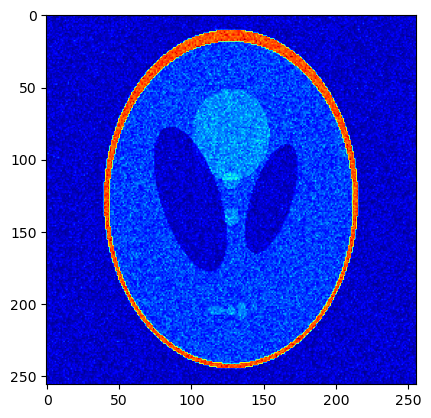

In [465]:
ans_adapt = gradient_descent_adapt(mat_data['imageNoisy'])
print("Denoised Image", RRMSE(ans_adapt, mat_data['imageNoiseless']))
print("Original Image", RRMSE(mat_data['imageNoisy'], mat_data['imageNoiseless']))

Optimal Parameters
alpha = 0.99
learning rate = 0.03
decay = 0.04
min step size = 1e-6

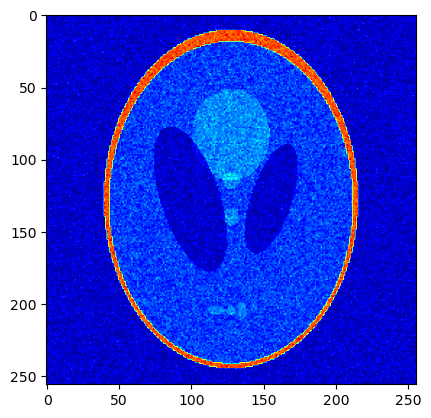

In [530]:
save_image(ans_adapt, "denoised_adapt.png")

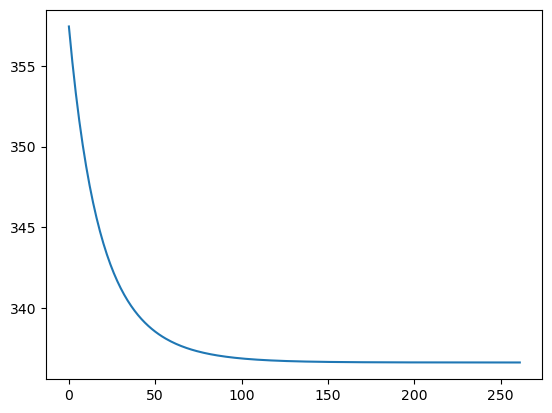

In [531]:
plt.plot(obj_adapt)
plt.show()

Paremeters in the proximity of optimum (20%)